In [5]:
import os,sys
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math

In [7]:
u0=4*math.pi*10**-7 #vacuum permeability
rpoCopper=1.68*10**-8



In [2]:
class Bullet:
    d=0
    v=0
    a=0
    def __init__(self,m,length,diameter,ur=6.3*10**-3,saturation=0.75):
        self.m=m #grams
        self.length=length #mm
        self.diameter=diameter #mm
        self.ur=ur #relative permeability
        self.caliber=np.pi*(self.diameter/2)**2  # crosssection area
        self.saturation=saturation   #saturation (Tesla)
    def getMaxForce(self):
        return self.saturation**2*self.caliber*10**-6/2/u0



In [437]:
class Coil:
    #default values
    L=0  # uH
    R=0  # Ohm
    n=0  # turns
    width=0   #mm
    innerDia=5  #mm
    outerDia=5  #mm
    gauge=20  #AWG
    AWGLUT={1:7.3481,2:6.5437,3:5.8273,4:5.1894,5:4.6213,6:4.1154,7:3.6649,8:3.2636,9:2.9064,10:2.5882,11:2.3048,12:2.0525,13:1.8278,14:1.6277,15:1.4495,16:1.2908,17:1.1495,18:1.0237,19:0.9116,20:0.8118,21:0.7229,22:0.6438,23:0.5733,24:0.5106,25:0.4547,26:0.4049,27:0.3606,28:0.3211,29:0.2859,30:0.2546,31:0.2268,32:0.2019,33:0.1798,34:0.1601,35:0.1426,36:0.1270,37:0.1131,38:0.1007,39:0.0897,40:0.0799}
    def __init__(self,n,innerDia,width,gauge): #input, n:turns, innerDia:inner diameter(mm), length(mm), gauge(awg)
        self.n=n
        self.width=width
        self.innerDia=innerDia
        self.gauge=gauge
        self.wireDia=self.AWGLUT[self.gauge]
        self.tpl=math.ceil(self.width/self.wireDia) # turns per layer
        self.width=self.tpl*self.wireDia # actual width
        self.layers=math.ceil(self.n/self.tpl)
        self.outerDia=self.innerDia+2*(self.layers*self.wireDia)    # return inner_dia + 2 * layer * wire_dia

        remainingTurns=self.n
        self.wireLength=0
        for layer in range(self.layers):
            D=self.innerDia+2*layer*self.wireDia
            if remainingTurns>= self.tpl:
                LayerL=self.tpl**2*u0*(D*10**-3/2)*(np.log(8*D/self.wireDia)-2)
                layerl=D*math.pi*self.tpl
            else:
                LayerL=remainingTurns**2*u0*(D*10**-3/2)*(np.log(8*D/self.wireDia)-2)
                layerl=D*math.pi*remainingTurns
#             print(LayerL, layerl)
            self.L+= LayerL
            self.wireLength +=layerl
            remainingTurns=remainingTurns-self.tpl
        self.L=self.L * 10**6 # H to uH
        self.R=rpoCopper*self.wireLength*10**-3/(math.pi*(self.wireDia*10**-3/2)**2)
#         print(self.__dict__)



In [452]:
class PowerSource:
    Ri=0.25
    V=20
    def __init__(self,Ri,V):
        self.Ri=Ri
        self.V=V

In [338]:
'''
Generates a normal vector for the force, to get force, multiply that by the max force
'''
def sigmoid(x,offset,width):
        return 1/(1+np.exp(10/width*(-x+1+offset)))
def posToForceVector(coil,proj,pos): #datum for coil back edge and proj is front edge
#     coil.width
    #datum transformation
    fullL=coil.width+proj.length
    relposB=pos-proj.length/2
    relposC=coil.width/2
#     print(relposB,relposC)
    dist=relposB-relposC
    
#     print(dist)
    
    forceSine=-math.sin(2*np.pi*dist/(fullL))
    fstInf=-(fullL)/4
    secInf=(fullL)/4
    
    def fstRmp(dist):
        return sigmoid(dist,(-3/8)*fullL,fullL/4) # function smooth switcher 
    def secRmp(dist):
        return sigmoid(dist,(3/8)*fullL,fullL/4) 
    def upRoll(dist):#inverse function for out of coil
        if dist>-fullL/4:
            return 1
        else:
            return 1/(-dist-fullL/4+1)
    def downRoll(dist):
        if dist<fullL/4:
            return -1
        else:
            return -1/((dist-fullL/4+1))
#     secRmp=lambda dist: (dist-secInf)/fstInf
#     print(fstInf,secInf)
    if dist<-fullL/2:
        force=upRoll(dist)
    elif dist>=-fullL/2 and dist<-fullL/4:
        force=upRoll(dist)*(1-fstRmp(dist))+(fstRmp(dist))*forceSine
    elif dist>=-fullL/4 and dist<=fullL/4:
        force=forceSine
    elif dist>=fullL/4 and dist<fullL/2:
        force=downRoll(dist)*secRmp(dist)+(1-secRmp(dist))*forceSine
    else:
        force=downRoll(dist)
#TODO: Replace ramp with ReLu
    return force
    return secRmp(dist)
#     return upRoll(dist)

In [426]:
def currentToForce(coil,current): # use MMF to Force TF to determine force scalar
    # exp data shows square relationship
    # need to plot MMf v F at fixed dist # don't care about voltage
    #use Matlab 3d curve fit to find func
    kc=0.0025#conversion  factor
    MMF=coil.n*current
    force=kc*MMF
    return force

{'n': 50, 'width': 25.0194, 'innerDia': 5, 'gauge': 24, 'wireDia': 0.5106, 'tpl': 49, 'layers': 2, 'outerDia': 7.042400000000001, 'wireLength': 788.6063578152941, 'L': 17.81893719743922, 'R': 0.06470205187049818}


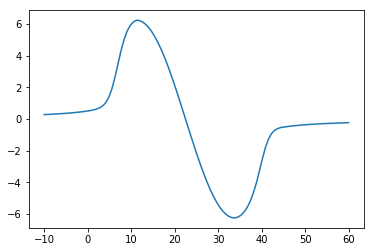

In [427]:
myCoil=Coil(50,5,25,24) #n,innerDia,width,gauge
ironBall=Bullet(2.9,20,4.76) #mass(g),length,diameter,ur=6.3*10**-3,saturation=0.75):



forceVec=[]
distTrain=np.linspace(-10,60,100)
for i in distTrain:
    forceVec.append(posToForceVector(myCoil,ironBall,i)*currentToForce(myCoil,50))
plt.plot(distTrain,forceVec)

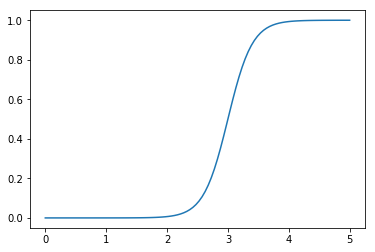

In [428]:
def PG(x,offset,width):
    return 1/(1+np.exp(10/width*(-x+1+offset)))
train=np.linspace(0,5,100)
vec=[]
for i in train:
    vec.append(PG(i,2,2))
plt.plot(train,vec)

In [499]:
class Stage():
    def __init__(self,coil,bullet,PS):
        self.coil=coil
        self.bullet=bullet
        self.PS=PS
    def idealStageSim(self,offset,enterV): # on offset dist, enter velocity(m/s)
        fullL=self.coil.width+self.bullet.length
        if enterV:
            simTime=(fullL*0.001)/enterV #mm to m
        else:
            simTime=0.02 #20ms default
        simSteps=500 # discrete steps
        dt=simTime/simSteps
        timeTrain=np.linspace(0,simTime,simSteps)
        current=self.PS.V/(self.PS.Ri+self.coil.R)
        FScalar=currentToForce(self.coil,current)#replace with real current estimate
        #Stage Variables:
        # V (velocity) m/s
        V=enterV
        # D (position, 0 is coil entrance) mm
        D=-offset
        # A (acceleration, result of force)
        A=0
        # 
        #Stage Variable Tracking Vectors
        Va=[]
        Da=[]
        Aa=[]
        Fa=[]
        for t in timeTrain:
            F=0
            if (D-self.bullet.length/2)<self.coil.width/2:# if center of bullet is before center of coil
                F=posToForceVector(self.coil,self.bullet,D)*FScalar
            A=F/(self.bullet.m/1000) # g to kg
            V=V+dt*A
            D=D+dt*V*1000 # m/s to mm/s
            Fa.append(F)
            Va.append(V)
            Aa.append(A)
            Da.append(D)
        exitV=np.interp(fullL,Da,Va)
#         print("exit velocity:"+str(exitV))
        lapseT=np.interp(fullL,Da,timeTrain)
#         print(str(lapseT*1000)+" ms to exit")
        onT=np.interp(fullL/2,Da,timeTrain)
#         print(str(onT*1000)+" ms pulse")
        plt.plot(Da,Va)
        energy=onT*current*self.PS.V
        return exitV, energy

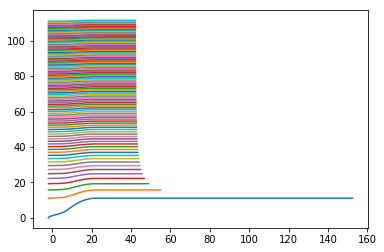

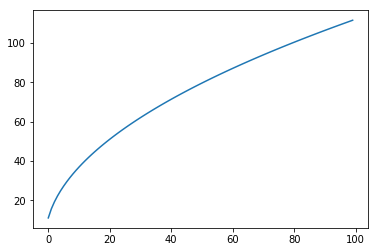

In [501]:
dowel=Bullet(2.9,18.75,4.76) #mass(g),length,diameter,ur=6.3*10**-3,saturation=0.75):
PS=PowerSource(0.5,40)

coil1=Coil(100,7.5,25,23) #n,innerDia,width,gauge\
# stage1=Stage(coil1,dowel)
# v1=stage1.idealStageSim(2,0)

Vs=0
Va=[]
Ea=[]
ua=[]
for i in range(100):
    stage1=Stage(coil1,dowel,PS)
    Vs,Es=stage1.idealStageSim(2,Vs)
    if i == 0:
        ua.append(0.5*dowel.m*(Vs-0)**2/Es)
    else:
        ua.append(0.5*dowel.m*(Vs-Va[-1])**2/Es)
    Va.append(Vs)
    Ea.append(Es)
# coil2=Coil(100,7.5,25,23) #n,innerDia,width,gauge\
# stage2=Stage(coil2,dowel)
# v2=stage2.idealStageSim(2,v1)
plt.figure()
plt.plot(Va)


Text(0, 0.5, 'efficiency')

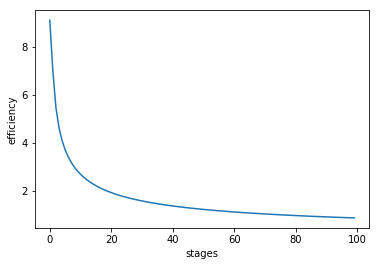

In [498]:

plt.figure()
plt.plot(ua)
plt.xlabel("stages")
plt.ylabel("efficiency")

In [486]:
Vs

111.46296309154931